# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import sys
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import RandomWarmUp2
import StaticDynamic
import DcOrient
import time
import DcOrientRandomSimple
import DcSimple
import StaticSimple
import BigBucketSimple
import SmallBucketSimple
import StaticRandom
import pickle

# Data Generation

In [35]:
G = misc.createRandomGraph(size=200, density=0.5, variation=0.4, maxDegree=None)
misc.graphInfo(G)

avg = misc.getAverageDegree(G)
variance = 0
degreeTuples = list(G.degree(list(G.nodes())))

for tuple in degreeTuples:
    variance += abs(avg - tuple[1])

variance = float(variance) / G.number_of_nodes()

variance

Nodes: 228
Edges: 12440
Density: 0.4807172115310302
Max Degree: 128
Average Degree: 109.12280701754386
Static Coloring uses 35 colors at the end


6.031702062172979

In [46]:
updates = misc.extractUpdates(G, 'prioritized')

In [44]:
updates = misc.extractStream(G, 10000, 0.5, 'random')

In [47]:
Ge = nx.Graph()
Ge.add_nodes_from(list(G.nodes()))

In [45]:
Ge = G.copy()

# Graph Saving and Loading

In [48]:
# Always define a name
name = 'test'

In [49]:
# Create graph data
nodes = list(Ge.nodes())
edges = list(Ge.edges())
updateEdges = list(update[0] for update in updates)
updateTypes = list(update[1] for update in updates)

ge = Ge.copy()
oldColoring = nx.coloring.greedy_color(ge)
newColoring = dict({})
staticColors = []
staticRecolors = []
for update in updates:
    if update[1]:
        ge.add_edge(update[0][0], update[0][1])
    else:
        ge.remove_edge(update[0][0], update[0][1])
    newColoring = nx.coloring.greedy_color(ge)
    staticColors.append(misc.numberOfColors(newColoring))
    staticRecolors.append(misc.numberOfRecolors(oldColoring, newColoring))
    oldColoring = newColoring

gd = misc.GraphData(name, nodes, edges, updateEdges, updateTypes, staticColors, staticRecolors)
totStaticColors = gd.colorSum
totStaticRecolors = gd.recolorSum

In [50]:
# Save graph data
misc.saveGraphData(gd)

In [27]:
# Load graph data
gd = misc.loadGraphData(name)

Ge = gd.G.copy()

updates = gd.updates
staticColors = gd.staticColors
staticRecolors = gd.staticRecolors
totStaticColors = gd.colorSum
totStaticRecolors = gd.recolorSum

# Get final state of graph in local memory as well
G = gd.G.copy()
for update in updates:
    if update[1]:
        G.add_edge(update[0][0], update[0][1])
    else:
        G.remove_edge(update[0][0], update[0][1])

# Algorithm Preparation

In [4]:
# Only run once
experiments = []

In [5]:
class Exp:
    def __init__(self, G, experimentList, name):
        self.G = G
        self.experimentList = experimentList
        self.name = name

In [6]:
experimentList = []

experimentList.append([RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up'])
# experimentList.append([RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2'])

d = 5
experimentList.append([SmallBucket.SmallBucketAlgo(d, Ge), 'Small-Bucket algorithm (d = '+str(d)+')', 10])

d = 5
experimentList.append([BigBucket.BigBucketAlgo(d, Ge), 'Big-Bucket algorithm (d = '+str(d)+')', 10])

l = 10
experimentList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])

l = 100
experimentList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])

experimentList.append([DcOrient.DcOrientAlgo(Ge), 'DC-Orient'])

l = 10
experimentList.append([StaticSimple.StaticSimpleAlgo(Ge, l), 'Static-Simple algorithm (l = ' +str(l)+ ')'])

l = 100
experimentList.append([StaticSimple.StaticSimpleAlgo(Ge, l), 'Static-Simple algorithm (l = ' +str(l)+ ')'])

p = 0.8
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Simple (p = '+ str(p) + ')'])

p = 0.998
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Simple (p = '+ str(p) + ')'])

In [12]:
experimentList = []
p = 0.0
experimentList.append([DcOrientRandomSimple.DcOrientRandomSimpleAlgo(Ge, p), 'DC-Orient without optimizations'])
experimentList.append([DcSimple.DcSimpleAlgo(Ge, p), 'DC-Orient with optimizations'])

In [7]:
experiments.append(Exp(G, experimentList, name))

In [8]:
for exp in experiments:
    print(exp.name)

200Random2


# Experimenting

In [9]:
def runExperiments(experiments, type='average'):

    validTypes = ['end', 'average', 'ratio']
    if type not in validTypes:
        print("Experiment type not valid, expected one of: " + str(validTypes))
        return


    for exp in experiments:
        
        G = exp.G
        experimentList = exp.experimentList
        name = exp.name

        # Load graph data
        gd = misc.loadGraphData(name)

        updates = gd.updates
        staticColors = gd.staticColors
        staticRecolors = gd.staticRecolors
        totStaticColors = gd.colorSum
        totStaticRecolors = gd.recolorSum

        # CSV Writer
        f = open('experiments/'+ str(name) + '.csv', 'w', newline='')
        writer = csv.writer(f)

        print('Graph used in the experiment:')
        misc.graphInfo(G)

        if (type == 'end'):
            C = staticColors[-1]
        elif (type == 'average'):
            C = round(float(totStaticColors)/len(updates), 2)
        elif (type == 'ratio'):
            C = 1
        row = [str(G.number_of_nodes()) + ' Nodes; ' + str(G.number_of_edges()) + ' Edges; C = ' + str(C),'Average nr. of Recolors', 'Average nr. of Colors', 'Time Taken (s)']
        writer.writerow(row)

        for experiment in experimentList:

            row = [str(experiment[1])]

            if len(experiment) == 3:
                random.seed(experiment[2])
            else:
                random.seed()

            print("")
            print("------------------------------------------------------------------")
            print(str(experiment[1]) + ":")
            iterator = misc.UpdateIterator(experiment[0], updates)

            recolors = 0
            colors = 0
            
            timer = 0
            verifytimer = 0
            colortimer = 0
            countertimer = 0
            
            while True:
                timestamp = time.perf_counter()
                if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
                    raise ValueError('The coloring produced is incorrect')
                verifytimer += time.perf_counter() - timestamp
                timestamp = time.perf_counter()
                c1 = iterator.algo.getColoring()
                if iterator.runUpdate(1):
                    timer += time.perf_counter() - timestamp
                    timestamp = time.perf_counter()
                    c2 = iterator.algo.getColoring()
                    colortimer += time.perf_counter() - timestamp
                    timestamp = time.perf_counter()
                    recolors += misc.numberOfRecolors(c1, c2)
                    colors += misc.numberOfColors(c2)
                    countertimer += time.perf_counter() - timestamp
                else:
                    #print("all updates finished")
                    break

            #timer = time.perf_counter() - timer

            print("")

            if (type == 'end'):
                # End values
                print('Results measured at the end')
                avgRecolors = float(recolors)/len(updates)
                print("Average number of recolors per update: " + str(avgRecolors))
                row.append(str(round(avgRecolors, 2)))
                finalColors = misc.numberOfColors(iterator.algo.getColoring())
                print("Final number of colors used: " + str(finalColors))
                row.append(str(finalColors))

            elif (type == 'average'):
                # Average values
                print("Resuts averaged over the entire update sequence")
                avgRecolors = float(recolors)/len(updates)
                print("Average number of recolors per update: " + str(avgRecolors))
                row.append(str(round(avgRecolors, 2)))
                avgColors = float(colors/len(updates))
                print("Average number of colors used: " + str(avgColors))
                row.append(str(round(avgColors, 2)))

            elif (type == 'ratio'):
                # Ratios
                print("Results given as a ratio")
                recolorRatio = float(recolors)/totStaticRecolors
                print("Ratio of recolors: " + str(recolorRatio))
                row.append(str(round(recolorRatio, 4)))
                colorRatio = float(colors)/totStaticColors
                print("Ratio of colors used: " + str(colorRatio))
                row.append(str(round(colorRatio, 4)))

            print("Time taken on algorithm : " + str(timer) + " seconds")
            row.append(str(round(timer, 3)))
            print("Time taken on verifying coloring: " + str(verifytimer) + " seconds")
            print("Time taken on counting colors and recolors: " + str(countertimer) + " seconds")
            print("Time taken on fetching the coloring: " + str(colortimer) + " seconds")
            # print("Average elementary operations : " + str(iterator.avgElemCounter))
            print("------------------------------------------------------------------")
            writer.writerow(row)

        print("End of experiment list reached")
        f.close()


In [10]:
runExperiments(experiments, 'average')

Graph used in the experiment:
Nodes: 244
Edges: 12542
Density: 0.42305876003508064
Max Degree: 123
Average Degree: 102.80327868852459
Static Coloring uses 34 colors at the end

------------------------------------------------------------------
Random Warm-Up:

Resuts averaged over the entire update sequence
Average number of recolors per update: 0.0596396109073513
Average number of colors used: 48.887657470897786
Time taken on algorithm : 1.8499143000002825 seconds
Time taken on verifying coloring: 24.1519367999999 seconds
Time taken on counting colors and recolors: 0.6546921000002506 seconds
Time taken on fetching the coloring: 1.6803106999994917 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 5):

Resuts averaged over the entire update sequence
Average number of recolors per update: 3.5735129963323233
Average number of colors used: 47.81534045606761
Time taken on

In [51]:
nx.info(experiments[0].experimentList[0][0].G)

'Graph with 215 nodes and 12933 edges'

In [52]:
misc.numberOfColors(nx.coloring.greedy_color(experiments[0].experimentList[0][0].G))

39

# Graph Generation Experiments

In [34]:
e = [['SmallBucket', 1, 30],
    ['BigBucket', 1, 30],
    ['StaticDynamic', 1, 200],
    ['StaticSimple', 1, 200],
    ['DcSimple', 0.4, 1],
    ['StaticRandom', 0.4, 1]]

iterations = 3

In [29]:
e = [['BigBucket', 1, 30],
    ['BigBucketSimple', 0, 1, 2],
    ['BigBucketSimple', 0, 1, 5],
    ['BigBucketSimple', 0, 1, 10],
    ['BigBucketSimple', 0, 1, 20],
    ['BigBucketSimple', 0, 1, 30]]

iterations = 3

In [35]:
coordinateLists = []
experimentListList = []

# Add a single iteration for the random warm ups
experimentList = []
tempList = []
for j in range(0, iterations):
    tempList.append([RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up'])
experimentList.append(tempList)
experimentListList.append(experimentList)

# experimentList = []
# experimentList.append([RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2'])
# experimentListList.append(experimentList)

for exp in e:
    # Add different algorithms one by one by changing parameters
    experimentList = []
    algo = exp[0]
    min = exp[1]
    max = exp[2]
    r = 100             # Number of experiments per algorithm
    current = min
    lastCurrent = -100
    for i in range(0, r):
        if algo == 'SmallBucket':
            d = int(current)
            if d != int(lastCurrent):
                experimentList.append([[SmallBucket.SmallBucketAlgo(d, Ge), 'Small-Bucket algorithm (d = '+str(d)+')', 10]])
        elif algo == 'BigBucket':
            d = int(current)
            if d != int(lastCurrent):
                experimentList.append([[BigBucket.BigBucketAlgo(d, Ge), 'Big-Bucket algorithm (d = '+str(d)+')', 10]])
        elif algo == 'BigBucketSimple':
            d = exp[3] #temporary
            p = current
            experimentList.append([[BigBucketSimple.BigBucketSimpleAlgo(d, p, Ge), 'Big-Bucket Simple algorithm (p = '+str(p)+')']])
        elif algo == 'SmallBucketSimple':
            d = 10
            p = current
            experimentList.append([[SmallBucketSimple.SmallBucketSimpleAlgo(d, p, Ge), 'Small-Bucket Simple algorithm (p = '+str(p)+')']])
        elif algo == 'StaticDynamic':
            l = int(current)
            if l != int(lastCurrent):
                tempList = []
                for j in range(0, iterations):
                    tempList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])
                experimentList.append(tempList)
        elif algo == 'StaticSimple':
            l = int(current)
            if l != int(lastCurrent):
                tempList = []
                for j in range(0, iterations):
                    tempList.append([StaticSimple.StaticSimpleAlgo(Ge, l=l), 'Static-Simple (l = '+str(l)+')'])
                experimentList.append(tempList)
        elif algo == 'DcSimple':
            p = current
            tempList = []
            for j in range(0, iterations):
                tempList.append([DcSimple.DcSimpleAlgo(Ge, p=p), 'DC-Simple (p = '+str(p)+')'])
            experimentList.append(tempList)
        elif algo == 'StaticRandom':
            p = current
            tempList = []
            for j in range(0, iterations):
                tempList.append([StaticRandom.StaticRandomAlgo(Ge, p=p), 'Static Random (p = '+str(p)+')'])
            experimentList.append(tempList)

        lastCurrent = current
        current = current + ((max-min)/100)

    experimentListList.append(experimentList)

# Append a single iteration of DC-Orient
experimentList = []
experimentList.append([[DcOrient.DcOrientAlgo(Ge), 'DC-Orient', 10]])
experimentListList.append(experimentList)

In [36]:
# Print first experiment for each added algorithm
for experiments in experimentListList:
    print(experiments[0][0][1])

Random Warm-Up
Small-Bucket algorithm (d = 1)
Big-Bucket algorithm (d = 1)
Static-Dynamic algorithm (l = 1)
Static-Simple (l = 1)
DC-Simple (p = 0.4)
Static Random (p = 0.4)
DC-Orient


In [3]:
def runGraphExperiments(experimentListList, name, type='average'):

    validTypes = ['end', 'average', 'ratio']
    if type not in validTypes:
        print("Experiment type not valid, expected one of: " + str(validTypes))
        return

    # Iterate over each algorithm
    for currentExperimentList in experimentListList:
        loadingBar = False

        print('Graph used in the experiment:')
        misc.graphInfo(G)

        coords = []

        # Iterate over each parameter set for an algorithm
        for experiments in currentExperimentList:

            iters = len(experiments)
            totRecolors = 0
            totColors = 0
            totTime = 0
            i = 0

            # Iterate over each identical iteration of the algorithm, to average results out
            for experiment in experiments:

                recolors = 0
                colors = 0

                if len(experiment) == 3:
                    random.seed(experiment[2])
                else:
                    random.seed()

                print("")
                print("------------------------------------------------------------------")
                print(str(experiment[1]) + ":")
                iterator = misc.UpdateIterator(experiment[0], updates)

                
                i += 1
                print("Iteration " + str(i))
                timer = 0
                verifytimer = 0
                colortimer = 0
                countertimer = 0
                totalUpdates = len(updates)
                done = 0
                barLength = 64

                if loadingBar:
                    #line to be overwritten
                    print("")

                while True:
                    
                    if loadingBar:
                        #overwrite previously printed line
                        percentageDone = int(done/totalUpdates*barLength)
                        b = ("[" + percentageDone * "+" + (barLength - percentageDone) * "-" + "]")
                        sys.stdout.write('\r'+b)
                        sys.stdout.flush()

                    timestamp = time.perf_counter()
                    # if not misc.verifyColoring(iterator.algo.G, iterator.algo.getColoring()):
                    #     raise ValueError('The coloring produced is incorrect')
                    verifytimer += time.perf_counter() - timestamp
                    timestamp = time.perf_counter()
                    c1 = iterator.algo.getColoring()
                    if iterator.runUpdate(1):
                        timer += time.perf_counter() - timestamp
                        timestamp = time.perf_counter()
                        c2 = iterator.algo.getColoring()
                        colortimer += time.perf_counter() - timestamp
                        timestamp = time.perf_counter()
                        recolors += misc.numberOfRecolors(c1, c2)
                        colors += misc.numberOfColors(c2)
                        countertimer += time.perf_counter() - timestamp
                        done += 1
                    else:
                        #print("all updates finished")
                        break

                #timer = time.perf_counter() - timer
                totTime += timer

                if loadingBar:
                    #overwrite previously printed line
                    b = ("")
                    sys.stdout.write('\r'+b)
                    sys.stdout.flush()

                avgRecolors = 4*float(recolors)/len(updates)
                avgColors = 4*float(colors)/len(updates)


                if (type == 'ratio'):
                    totRecolors += float(recolors)/totStaticRecolors
                    b = "Ratio of recolors: " + str(float(recolors)/totStaticRecolors)
                else:
                    totRecolors += avgRecolors
                    b = "Average number of recolors per update: " + str(avgRecolors)
                b = b + (barLength + 2 - len(b)) * " "
                print(b)

                if (type == 'end'):
                    totColors += misc.numberOfColors(iterator.algo.getColoring())
                    print("Total number of colors used at the end: " + str(misc.numberOfColors(iterator.algo.getColoring())))
                elif (type == 'average'):
                    totColors += avgColors
                    print("Average number of colors used: " + str(avgColors))
                elif (type == 'ratio'):
                    totColors += float(colors)/totStaticColors
                    print("Ratio of number of colors used: " + str(float(colors)/totStaticColors))


                print("Time taken on algorithm : " + str(timer) + " seconds")
                print("Time taken on verifying coloring: " + str(verifytimer) + " seconds")
                print("Time taken on counting colors and recolors: " + str(countertimer) + " seconds")
                print("Time taken on fetching the coloring: " + str(colortimer) + " seconds")
                #print("Average elementary operations : " + str(iterator.avgElemCounter))
                print("------------------------------------------------------------------")
            coords.append([totRecolors/iters, totColors/iters, totTime/iters])

        print("End of experiment list reached")
        coordinateLists.append(coords)
        # Save pickled coordinateLists
        with open('experiments/' + str(name)+' coordinateLists.pkl', 'wb') as f:
            pickle.dump(coordinateLists, f)


In [38]:
runGraphExperiments(experimentListList, name, 'average')

Graph used in the experiment:
Nodes: 200
Edges: 11940
Density: 0.6
Max Degree: 139
Average Degree: 119.4
Static Coloring uses 41 colors at the end

------------------------------------------------------------------
Random Warm-Up:
Iteration 1
Average number of recolors per update: 0.21943048576214405        
Average number of colors used: 217.18291457286432
Time taken on algorithm : 1.421125499983873 seconds
Time taken on verifying coloring: 0.0011766999955398205 seconds
Time taken on counting colors and recolors: 0.47754919997419165 seconds
Time taken on fetching the coloring: 1.348835500001769 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Random Warm-Up:
Iteration 2
Average number of recolors per update: 0.2150753768844221         
Average number of colors used: 217.3896147403685
Time taken on algorithm : 1.430126899992274 seconds
Time taken on verifying coloring: 0.0011867999944570329 se

In [11]:
name = 'StreamDecaying'

In [16]:
# Save pickled coordinateLists
with open('experiments/' +str(name)+' coordinateLists.pkl', 'wb') as f:
    pickle.dump(coordinateLists, f)

In [12]:
# Load pickled coordinateLists
with open('experiments/' + str(name)+' coordinateLists.pkl', 'rb') as f:
    coordinateLists = pickle.load(f)

In [18]:
coordinateLists

[[[0.93394777265745, 32.22734254992319, 0.004960899999853534]],
 [[1.5852534562211982, 95.46543778801843, 0.015993399999786106],
  [8.700460829493087, 49.03225806451613, 0.01681070000020668],
  [9.622119815668203, 50.175115207373274, 0.01871390000033557],
  [10.433179723502304, 46.80184331797235, 0.020013799999929915],
  [12.276497695852534, 38.3778801843318, 0.01863559999966924],
  [12.073732718894009, 42.74654377880184, 0.022187799999755953],
  [11.981566820276498, 43.53917050691244, 0.025089200000053324],
  [11.981566820276498, 43.53917050691244, 0.02343720000001781],
  [11.981566820276498, 43.53917050691244, 0.023785499999746662],
  [11.981566820276498, 43.53917050691244, 0.024209699999886425],
  [11.981566820276498, 43.53917050691244, 0.02634609999986992],
  [11.981566820276498, 43.53917050691244, 0.02987229999973806],
  [11.981566820276498, 43.53917050691244, 0.02534900000006246],
  [11.981566820276498, 43.53917050691244, 0.024276899999762236],
  [11.981566820276498, 43.539170506

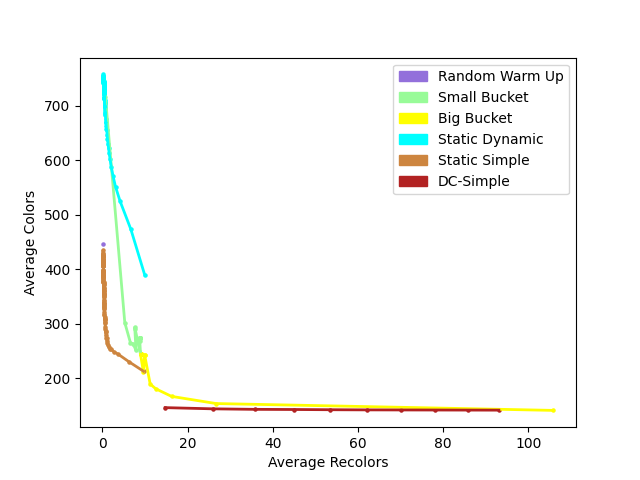

In [13]:
plt.close()

algoNames = ['Random Warm Up', 'Small Bucket', 'Big Bucket', 'Static Dynamic', 'Static Simple', 'DC-Simple', 'Static Random', 'DC-Orient']
colorDict = matplotlib.colors.CSS4_COLORS
colors = [colorDict.get('mediumpurple'), colorDict.get('palegreen'), colorDict.get('yellow'), colorDict.get('cyan'), colorDict.get('peru'), colorDict.get('firebrick'), colorDict.get('pink'), colorDict.get('navy')]
patches = []


j = 0
for list in coordinateLists:

    if not (j == 6):

        color = colors[j]
        patch = matplotlib.patches.Patch(color=color, label=algoNames[j])
        patches.append(patch)
        
        xcoords = [i[0] for i in list]
        ycoords = [i[1] for i in list]

        # Original line plot
        plt.plot(xcoords, ycoords, c=color, linewidth=2)

        # Points plot
        plt.scatter(xcoords, ycoords, c=color, s=5)

    j += 1

# Adjust labels depending on type of experiment
plt.xlabel("Average Recolors")
plt.ylabel("Average Colors")
plt.legend(handles=patches)
plt.show()

[(1, 2), (2, 3)]


(1 2)
(1 3)
(1 2)
(2 3)


[0, 1]

# Full Graph Experiment

In [7]:
names = ['GraphDegreeFiar', 'GraphDegreeSkewedAdditive', 'GraphDegreeSkewedSquared', 'UpdateSequenceRandom', 'UpdateSequenceExpanding', 'UpdateSequencePrioritized']
for name in names:
    #Imports
    %matplotlib widget
    import pandas as pd
    import numpy as np
    import csv
    import matplotlib
    import matplotlib.pyplot as plt
    import scipy
    import datetime
    import networkx as nx
    import misc
    import math
    import sys
    import random
    import SmallBucket
    import BigBucket
    import RandomWarmUp1
    import RandomWarmUp2
    import StaticDynamic
    import DcOrient
    import time
    import DcOrientRandomSimple
    import DcSimple
    import StaticSimple
    import BigBucketSimple
    import SmallBucketSimple
    import StaticRandom
    import pickle

    # Load graph data
    gd = misc.loadGraphData(name)

    Ge = gd.G.copy()

    updates = gd.updates
    staticColors = gd.staticColors
    staticRecolors = gd.staticRecolors
    totStaticColors = gd.colorSum
    totStaticRecolors = gd.recolorSum

    # Get final state of graph in local memory as well
    G = gd.G.copy()
    for update in updates:
        if update[1]:
            G.add_edge(update[0][0], update[0][1])
        else:
            G.remove_edge(update[0][0], update[0][1])

    e = [['SmallBucket', 1, 30],
    ['BigBucket', 1, 30],
    ['StaticDynamic', 1, 200],
    ['StaticSimple', 1, 200],
    ['DcSimple', 0.4, 1]]

    iterations = 3

    coordinateLists = []
    experimentListList = []

    # Add a single iteration for the random warm ups
    experimentList = []
    tempList = []
    for j in range(0, iterations):
        tempList.append([RandomWarmUp1.WarmUp1Algo(Ge, maxDegreeBound=None), 'Random Warm-Up'])
    experimentList.append(tempList)
    experimentListList.append(experimentList)

    # experimentList = []
    # experimentList.append([RandomWarmUp2.WarmUp2Algo(Ge, maxDegreeBound=None), 'Random Warm-Up 2'])
    # experimentListList.append(experimentList)

    for exp in e:
        # Add different algorithms one by one by changing parameters
        experimentList = []
        algo = exp[0]
        min = exp[1]
        max = exp[2]
        r = 100             # Number of experiments per algorithm
        current = min
        lastCurrent = -100
        # if algo == 'DcSimple':  # TEMP
        #      r = 10
        for i in range(0, r):
            if algo == 'SmallBucket':
                d = int(current)
                if d != int(lastCurrent):
                    experimentList.append([[SmallBucket.SmallBucketAlgo(d, Ge), 'Small-Bucket algorithm (d = '+str(d)+')', 10]])
            elif algo == 'BigBucket':
                d = int(current)
                if d != int(lastCurrent):
                    experimentList.append([[BigBucket.BigBucketAlgo(d, Ge), 'Big-Bucket algorithm (d = '+str(d)+')', 10]])
            elif algo == 'BigBucketSimple':
                d = exp[3] #temporary
                p = current
                experimentList.append([[BigBucketSimple.BigBucketSimpleAlgo(d, p, Ge), 'Big-Bucket Simple algorithm (p = '+str(p)+')']])
            elif algo == 'SmallBucketSimple':
                d = 10
                p = current
                experimentList.append([[SmallBucketSimple.SmallBucketSimpleAlgo(d, p, Ge), 'Small-Bucket Simple algorithm (p = '+str(p)+')']])
            elif algo == 'StaticDynamic':
                l = int(current)
                if l != int(lastCurrent):
                    tempList = []
                    for j in range(0, iterations):
                        tempList.append([StaticDynamic.StaticDynamicAlgo(Ge, l, dynamicReset=False), 'Static-Dynamic algorithm (l = '+str(l)+')'])
                    experimentList.append(tempList)
            elif algo == 'StaticSimple':
                l = int(current)
                if l != int(lastCurrent):
                    tempList = []
                    for j in range(0, iterations):
                        tempList.append([StaticSimple.StaticSimpleAlgo(Ge, l=l), 'Static-Simple (l = '+str(l)+')'])
                    experimentList.append(tempList)
            elif algo == 'DcSimple':
                p = current
                tempList = []
                for j in range(0, iterations):
                    tempList.append([DcSimple.DcSimpleAlgo(Ge, p=p), 'DC-Simple (p = '+str(p)+')'])
                experimentList.append(tempList)
            elif algo == 'StaticRandom':
                p = current
                tempList = []
                for j in range(0, iterations):
                    tempList.append([StaticRandom.StaticRandomAlgo(Ge, p=p), 'Static Random (p = '+str(p)+')'])
                experimentList.append(tempList)

            lastCurrent = current
            
            # if (algo == 'DcSimple'):
            #      current = current + ((max-min)/10)  #TEMP
            # else:
            current = current + ((max-min)/100)

        experimentListList.append(experimentList)

    # Append a single iteration of DC-Orient
    experimentList = []
    experimentList.append([[DcOrient.DcOrientAlgo(Ge), 'DC-Orient', 10]])
    experimentListList.append(experimentList)

    runGraphExperiments(experimentListList, name, 'average')

    # Save pickled coordinateLists
    with open('experiments/' + str(name)+' coordinateLists.pkl', 'wb') as f:
        pickle.dump(coordinateLists, f)

    print(str(name) + ' experiment done!')

Graph used in the experiment:
Nodes: 200
Edges: 10292
Density: 0.5171859296482412
Max Degree: 125
Average Degree: 102.92
Static Coloring uses 35 colors at the end

------------------------------------------------------------------
Random Warm-Up:
Iteration 1
Average number of recolors per update: 0.02496                    
Average number of colors used: 443.89856
Time taken on algorithm : 12.065542398093385 seconds
Time taken on verifying coloring: 0.009437599292141385 seconds
Time taken on counting colors and recolors: 4.167893403049675 seconds
Time taken on fetching the coloring: 11.558546199594275 seconds
------------------------------------------------------------------

------------------------------------------------------------------
Random Warm-Up:
Iteration 2
Average number of recolors per update: 0.02416                    
Average number of colors used: 450.91712
Time taken on algorithm : 12.366464498874848 seconds
Time taken on verifying coloring: 0.009612601774279028 seco

# Results

In [74]:
runExperiments(experiments)

Graph used in the experiment:
Nodes: 119
Edges: 4531
Density: 0.6453496652898447
Max Degree: 91
Average Degree: 76.15126050420169
Static Coloring uses 30 colors

------------------------------------------------------------------
Small-Bucket algorithm (d = 1):

Average number of recolors per update: 0.286470977709115
Total number of colors used at the end: 119
Time taken : 5.674505700000736 seconds
Average elementary operations : 1.1302140807768704
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 3):

Average number of recolors per update: 3.1505186493047894
Total number of colors used at the end: 56
Time taken : 4.820692299999791 seconds
Average elementary operations : 3.221584639152505
------------------------------------------------------------------

------------------------------------------------------------------
Small-Bucket algorithm (d = 5):

Average number of rec

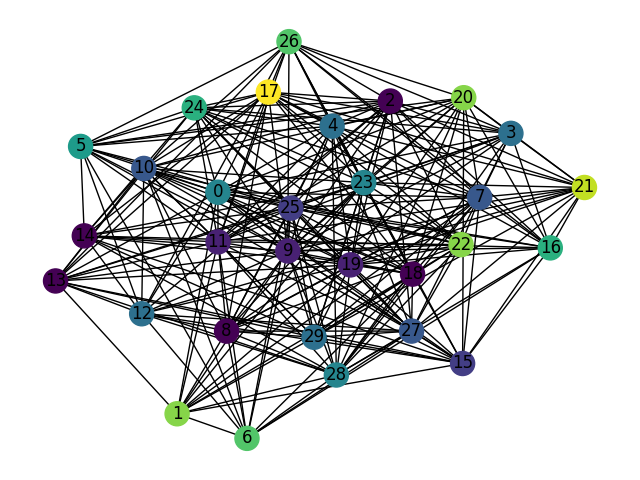

True
